# 不同策略的回测结果

除标记为`2019年数据`的数据外都是使用的历史数据（`2014-01-01`至`2018-12-31`）对不同的开仓和平仓策略进行的测试。所有策略中使用的参数均未做优化（也许是运气好得到了不错的结论，也有可能会有更优化的参数。但是会陷入过度优化陷阱）

从使用历史数据测试结果来看，所有策略的R值均在3以上。应该还算是一个不错的策略。

使用`2019年数据（2019-01-01~2019-12-31）`的测试结果也对其有了一定程度的验证。R值达到了`4.12`。

仓位控制：采用凯利公式对仓位进行控制后，由于单次买入的数量增加（原本平均开仓费用为1372.12，现在为4315.54），资金利用率由19.52%提高至31.14%，造成了交易数量由13次减少为8次（加仓次数减少），胜率由69.23%降低至50.00%。虽然因为仓位的增大带来了更高的亏损交易平均交易额（相对扩大142.84%），但是也正是因此而带来了更高的盈利交易平均盈利额（相对扩大252.93%）。所以最终R值由`4.12`上升至`4.14`。最终利润由`37.90%`上升至`59.45%`。

**策略说明：**

- 买入：收盘价上穿20日移动均线+20日ATR
- 买入（加仓）：收盘价高于20日移动均线+20日ATR，并且收盘价超过现有持仓的当时买入价+2倍买入日ATR
- 卖出：收盘价下穿20日移动均线+20日ATR
- 卖出：持仓达到20日（以历史数据的亏损交易平均持仓时间为值），并且当日价格小于或等于现有持仓的当时买入价

|                                                                                      |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-------------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道                                                            |   16441.3  |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |             -76.665  | 3.66 |  -0.223107 |        2209.86 |
| 回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略                                 |   16225.9  |    25080.6 |         52 |         27 |         25 |   0.519231 |              281.939 |              600.96  |             -62.6025 | 4.5  |  -0.223107 |        2217.84 |
| 回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）                           |   16441.3  |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |             -76.665  | 3.66 |  -0.223107 |        2209.86 |
| 回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略                         |   20867.4  |    28315.8 |         60 |         32 |         28 |   0.533333 |              305.168 |              652.107 |             -91.3329 | 3.34 |  -0.267097 |        2293.85 |
| 回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略                              |   20829.2  |    28809.5 |         60 |         31 |         29 |   0.516667 |              309.429 |              671.91  |             -78.0504 | 3.96 |  -0.267097 |        2297.82 |
| 回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略(2019年数据)                  |    3790.53 |    13610.8 |         13 |          9 |          4 |   0.692308 |              271.289 |              421.17  |             -65.9443 | 4.11 |  -0.310902 |        1372.12 |
| 回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略+凯利公式仓位控制(2019年数据) |    5945.68 |    15575.7 |          8 |          4 |          4 |   0.5      |              663.138 |             1486.42  |            -160.143  | 4.14 |  -0.333603 |        4315.54 |

**值得注意的是所有测试均只采用了300378一只股票进行测试。**

**蒙特卡洛模拟**

采用完整数据（2014-01-01\~2020-05-20），从中随机选出500\~1500天的连续数据，分别进行3轮测试（100次，1000次，10000次）。使用凯利公式对仓位进行管理。

每轮测试中大约有66%\~75%的测试结果中的交易次数是超过30笔的。这其中R乘数的均值和中位数在`2.4~2.6`之间。

|   测试轮数 |   count |    mean |      std |   min |    25% |   50% |    75% |   max |
|-----------:|--------:|--------:|---------:|------:|-------:|------:|-------:|------:|
|        100 |      75 | 2.61867 | 0.998608 |  0.64 | 1.935  | 2.6   | 3.36   |  4.51 |
|       1000 |      66 | 2.5353  | 1.00721  |  0.64 | 1.8175 | 2.475 | 3.36   |  5.1  |
|      10000 |      60 | 2.4025  | 1.11402  |  0.05 | 1.5225 | 2.485 | 3.2625 |  4.62 |

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()

Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\hquotes.py
Finding macros in 'macropy.core.hquotes'
Importing macros from 'macropy.core.quotes' into 'macropy.core.hquotes'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\quotes.py
Finding macros in 'macropy.core.quotes'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\failure.py
Finding macros in 'macropy.core.failure'
Importing macros from 'macropy.core.hquotes' into 'macropy.core.failure'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\numba\core\pythonapi.py
Finding macros in 'numba.core.pythonapi'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\numba\core\rewrites\__init__.py
Finding macros in 'numba.core.rewrites'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\numba\core\rewrites\macros.py
Finding macros in 'numba.core.rewrites.

# 原始数据

In [2]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

'DataFrame' object has no attribute 'date'
use old model qfq


# 数据初始化

In [3]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [4]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [5]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

In [6]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA
from QUANTAXIS.QAIndicator.talib_series import BBANDS

class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol,start=self.benchmark.start,end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['ma']=SMA(data['close'],20)
            data['atr']=calc_atr(high, low, pre_close, 20)
            data['up']=data['ma']+data['atr']
            data['low']=data['ma']-data['atr']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            # 收盘价上穿20日移动均线+20日ATR
            data['buy']=QA.QAIndicator.CROSS(data['close'],data['up'])
            # 收盘价下穿20日移动均线-20日ATR
            data['sell']=QA.QAIndicator.CROSS(data['low'],data['close'])
            result = data[self.benchmark.start:self.benchmark.end]
            result.name = data.name
        else:
            return data
#         logging.info(result)
        return result

## 初始化数据读取示例

In [7]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300', start='2014-01-01', end='2018-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [8]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [9]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    fig, ax1 = gquant.plt.subplots()
    # 绘制完整布林带买卖盈亏示例
    data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
    if 'buy' in data:
        ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
    if 'sell' in data:
        ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                    ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    cols2=kwargs.pop('cols2',[])
    if cols2:
        ax2 = ax1.twinx()
        data[cols2].plot(ax=ax2,ls='--')
        ax2.tick_params(axis='y')
    fig.tight_layout()
    gquant.plt.show()
    
    if simple_profit:
        # 绘制单次盈亏比率柱状图
        simple_profit=gquant.pd.Series(simple_profit)
        simple_profit.round(2).sort_index().plot(kind='bar',figsize=(20,3),title='单次盈亏比率')
        gquant.plt.show()
    
        # 绘制盈亏占比饼图
        gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
        gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

## ATR波幅通道

- 买入：收盘价上穿20日移动均线+20日ATR
- 卖出：收盘价下穿20日移动均线-20日ATR

测试了2014~2018年之间的数据。

|                               |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-通道策略-ATR波幅通道 |                0.19763 |       0.699342 |             -0.0775055 |      -0.212726 |      0.0173688 |         58 |     1198 |        27.1034 |                0.26578 |             0.310914 |

问题：[简单测试的问题说明](#%E7%AE%80%E5%8D%95%E6%B5%8B%E8%AF%95)

In [10]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')

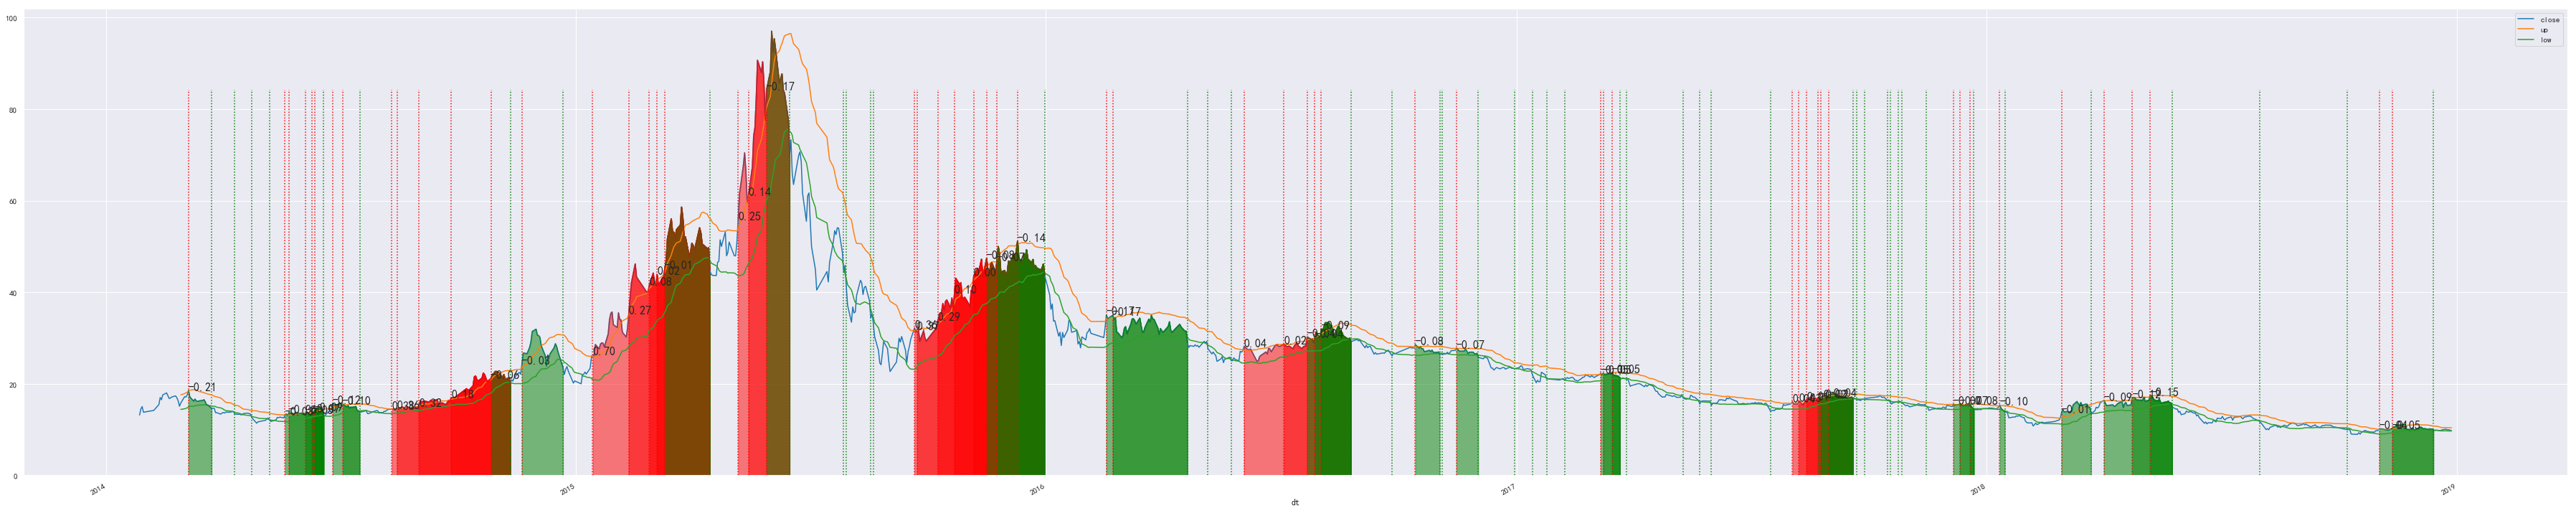

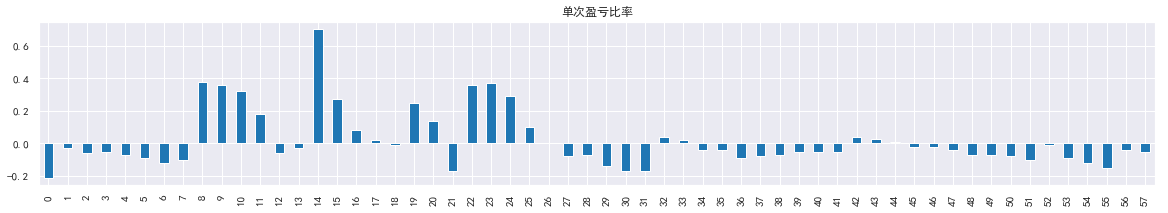

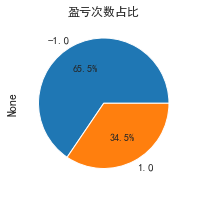

In [11]:
st1=simple_test(simple_data,cols1=['close','up','low'])

In [12]:
st1.name="简单测试-通道策略-ATR波幅通道"
print(st1.to_frame().T.to_markdown())

|                               |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-通道策略-ATR波幅通道 |                0.19763 |       0.699342 |             -0.0775055 |      -0.212726 |      0.0173688 |         58 |     1198 |        27.1034 |                0.26578 |


# 训练回测

## 仓位控制方法

In [13]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [14]:
def backtest(buy_factors,sell_factors,init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark('000300', start, end)
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        ['300378'],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 回测结果绘图

In [15]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

## ATR波幅通道

- 买入：收盘价上穿20日移动均线+20日ATR
- 卖出：收盘价下穿20日移动均线-20日ATR

- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                           |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:--------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道 |    16441.3 |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |              -76.665 | 3.66 |  -0.223107 |        2209.86 |

### 数据预处理

In [16]:
# class KLManager1(abupy.AbuKLManager):
#     def _fetch_pick_time_kl_pd(self, target_symbol):
#         data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol)
#         if not data.empty:
#             high = data['high']
#             low = data['low']
#             pre_close = data['pre_close']
#             data['atr14'] = calc_atr(high, low, pre_close, 14)
#             data['atr21'] = calc_atr(high, low, pre_close, 21)
#             for ma in [10,20]:
#                 data['ma{}'.format(ma)] = SMA(data.close,timeperiod=ma)
#             # 短期均线(10日)上穿长期均线(20日)
#             data['buy']=QA.QAIndicator.CROSS(data['ma10'],data['ma20'])
#             # 长期均线(20日)上穿短期均线(10日)（卖出）
#             data['sell']=QA.QAIndicator.CROSS(data['ma20'],data['ma10'])
#         result = data[self.benchmark.start:self.benchmark.end]
#         result.name = data.name
#         return result

### 买卖策略

In [17]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if today['buy']:
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['sell']:
            for order in orders:
                self.sell_tomorrow(order)

In [18]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=16652 begin work'), FloatProgress(value=0.0)))

### 结果

In [19]:
print(bt1.profit_series(name='回测-通道策略-ATR波幅通道').to_frame().T.to_markdown())

|                           |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:--------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道 |    16441.3 |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |              -76.665 | 3.66 |  -0.223107 |        2209.86 |


### 结果绘图

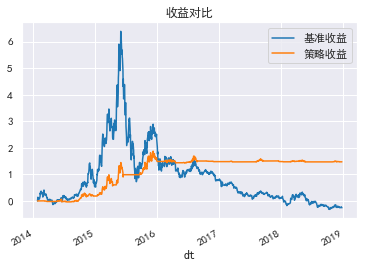

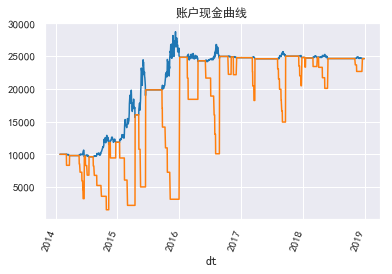

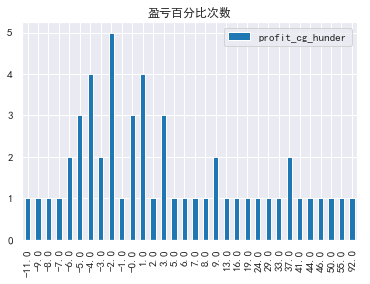

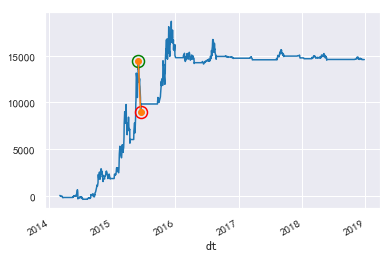

最大回撤: 0.223492
最大回测启始时间:2015-06-02, 结束时间2015-06-16, 共回测5459.245000
策略持股天数平均数: 38.207
策略持股天数中位数: 32.000


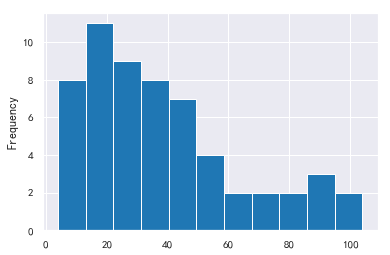

因子平均生效间隔:33.568627450980394


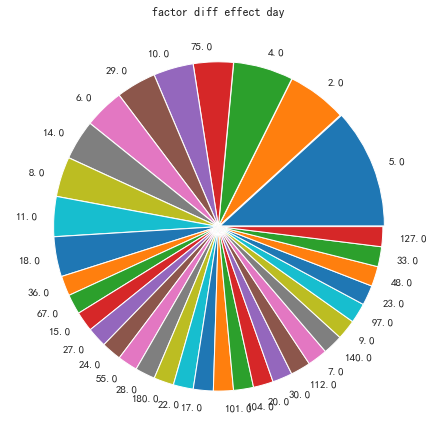

开仓花费情况: 
count:52
max:5740.339009123438
min:964.1420532129625
mean:2209.8621594823308
std:1027.7318148536435
skewness:1.4039812489964314
kurtosis:1.9289115786640334


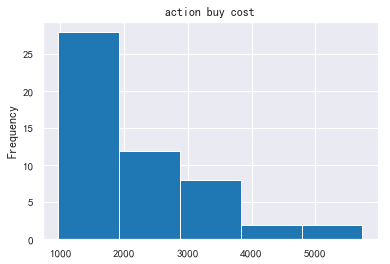

In [20]:
plot_cum_returns(bt1)
plot_capital_blance(bt1)
plot_win_loss_bar(bt1)
bt1.plot_max_draw_down()
bt1.plot_keep_days()
bt1.plot_effect_mean_day()
bt1.plot_action_buy_cost()

买入后卖出的交易数量:58
买入后尚未卖出的交易数量:0
胜率:58.6207%
平均获利期望:18.7781%
平均亏损期望:-3.9161%
盈亏比:7.6317
策略收益: 147.4255%
基准收益: -25.7539%
策略年化收益: 31.0110%
基准年化收益: -5.4174%
策略买入成交比例:89.6552%
策略资金利用率比例:17.5703%
策略共执行1198个交易日


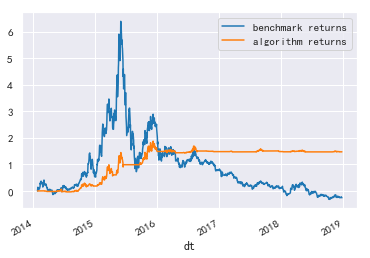

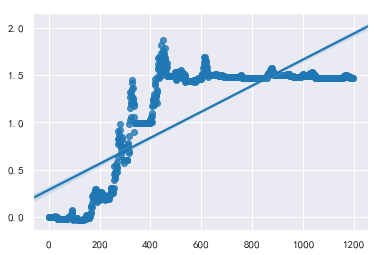

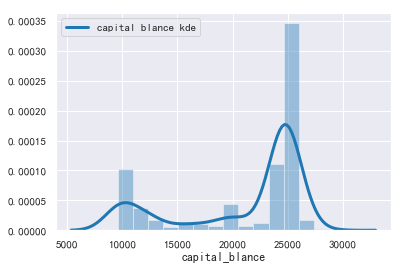

In [21]:
bt1.plot_returns_cmp()

通过盈利/亏损交易的持仓时间分析来看，不应该使用持仓N天之后就卖出的止损策略（啪啪打脸）

In [22]:
import logging
logging.info('盈利交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit>0].keep_days.describe())
logging.info('亏损交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit<=0].keep_days.describe())

盈利交易持仓时间
count     34.0000
mean      50.5882
std       25.1470
min       15.0000
25%       30.5000
50%       43.0000
75%       69.0000
max      104.0000
Name: keep_days, dtype: float64
亏损交易持仓时间
count    24.0000
mean     20.6667
std      15.1906
min       4.0000
25%      12.5000
50%      17.5000
75%      21.7500
max      63.0000
Name: keep_days, dtype: float64


## 增加最多持仓天数的卖出策略

### 卖出策略

In [23]:
class SellStrategy2(abupy.AbuFactorSellBase):
    """n日卖出策略。当N日后股价小于等于买入价时卖出。"""

    def _init_self(self, **kwargs):
        """kwargs中可以包含: 参数sell_n：代表买入后持有的天数，默认20天"""
        self.sell_n = kwargs.pop('sell_n', 20)
        self.sell_type_extra = '{}:sell_n={}'.format(self.__class__.__name__, self.sell_n)

    def support_direction(self):
        """因子支持两个方向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]


    def fit_day(self, today, orders):
        for order in orders:
            # 将单子的持有天数进行增加
            order.keep_days += 1
            if order.keep_days >= self.sell_n and order.buy_price>=today.close:
                self.sell_tomorrow(order)

In [24]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
}]
bt2 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=16652 begin work'), FloatProgress(value=0.0)))

### 结果

以20日（亏损交易的平均持仓天数）为参数值。增加了此止损策略后，虽然盈利次数减少了，但是亏损交易的平均亏损额大幅下降，从而实现了最终价值的增加。R值竟然上涨到了4.93。

In [25]:
print(bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略').to_frame().T.to_markdown())

|                                                      |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |   R |   最大回撤 |   买入平均花费 |
|:-----------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略 |    16225.9 |    25080.6 |         52 |         27 |         25 |   0.519231 |              281.939 |               600.96 |             -62.6025 | 4.5 |  -0.223107 |        2217.84 |


In [26]:
gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-通道策略-ATR波幅通道,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略,16225.9071,25080.609,52.0,27.0,25.0,0.5192,281.9393,600.9595,-62.6025,4.50,-0.2231,2217.8440


## 增加止损(1倍ATR）止盈（10倍ATR）

In [27]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': abupy.AbuFactorAtrNStop,
    'stop_loss_n': 1,
    'stop_win_n': 10
}]
bt3 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=16652 begin work'), FloatProgress(value=0.0)))

### 结果

*原本就是以1倍的20日ATR作为上轨买入，跌破中轨时卖出。所以实际意义上就是以ATR作为止损线。实际测试中也是结果数据与不增加此方法的止盈止损一致。*

In [28]:
print(bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）').to_frame().T.to_markdown())

|                                                            |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-----------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR） |    16441.3 |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |              -76.665 | 3.66 |  -0.223107 |        2209.86 |


In [29]:
gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-通道策略-ATR波幅通道,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略,16225.9071,25080.609,52.0,27.0,25.0,0.5192,281.9393,600.9595,-62.6025,4.50,-0.2231,2217.8440
回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622


## (当前收盘价-当前均价)与当前ATR之间的倍数关系

count    1179.0000
mean       -0.1431
std         1.2950
min        -3.5506
25%        -1.0930
50%        -0.1670
75%         0.7751
max         3.7739
dtype: float64


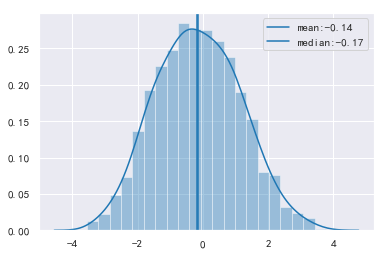

In [42]:
a=(simple_data['close']-simple_data['ma'])/simple_data['atr']
gquant.sns.distplot(a.dropna())
gquant.plt.axvline(x=a.mean(), ymin=0, ymax=1,label='mean:{:.2f}'.format(a.mean()))
gquant.plt.axvline(x=a.median(), ymin=0, ymax=1,label='median:{:.2f}'.format(a.median()))
gquant.plt.legend()
logging.info(a.describe())

## 增加超过三倍ATR时的止盈策略

根据上图，因为最大的倍数为`3.7739`，所以尝试增加倍数超过3倍ATR时止盈的策略。

效果并不好，违反了让利润奔跑的原则。

### 止盈策略

In [54]:
class SellStrategy3(abupy.AbuFactorSellBase):
    """n日卖出策略。当N日后股价小于等于买入价时卖出。"""

    def _init_self(self, **kwargs):
        """kwargs中可以包含: 参数sell_n：代表买入后持有的天数，默认20天"""
        self.sell_n = kwargs.pop('sell_n', 20)
        self.sell_type_extra = '{}:sell_n={}'.format(self.__class__.__name__, self.sell_n)

    def support_direction(self):
        """因子支持两个方向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]


    def fit_day(self, today, orders):
        for order in orders:
            if (today['ma']+3*today['atr'])<today['close']:
                self.sell_tomorrow(order)

In [55]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy3,
}]
bt6 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=16652 begin work'), FloatProgress(value=0.0)))

### 结果

In [56]:
gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt6.profit_series(name='回测-通道策略-ATR波幅通道-增加超过三倍ATR时的止损策略')], axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-通道策略-ATR波幅通道,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略,16225.9071,25080.609,52.0,27.0,25.0,0.5192,281.9393,600.9595,-62.6025,4.50,-0.2231,2217.8440
回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加超过三倍ATR时的止损策略,15774.1169,23682.282,53.0,28.0,25.0,0.5283,258.0753,563.3613,-83.8451,3.08,-0.2206,2312.6819


## 增加有持仓情况下2倍ATR时的加仓策略

因为有1倍ATR止损的存在，所以可以考虑在2倍ATR时加仓（让利润奔跑。*当当前股价超过购买时股价2倍ATR时，当时的仓位就已经是安全的了*）。

### 买入策略（加仓）

In [46]:
class BuyStrategy2(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if self.orders:
            o=self.orders[-1]
            if o.sell_date is None:
                buy=self.kl_pd[self.kl_pd['date']==o.buy_date]#最后一次购买当日的信息
                atr=buy.iloc[0]['atr']#最后一次购买当日的atr数据
                if today.close>today.up and today.close>o.buy_price+2*atr:
                    #当天价格在波幅通道之上，并且当天收盘价大于最后一次购买价格+2倍购买日atr（可加仓价）
#                     import logging
#                     logging.info('{}:当日收盘价:{:.2f},当日波幅上轨:{:.2f},购买日:{},购买价格:{:.2f},购买日ATR:{:.2f}'.format(today.date,today.close,today.up,o.buy_date,o.buy_price,atr))
                    return self.buy_tomorrow()

In [47]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class':BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]
bt4= backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=16652 begin work'), FloatProgress(value=0.0)))

### 结果

相对不增加加仓策略时，总利润有所增加。但是盈亏均有所放大。并且最大回撤也由22.31%上涨到了26.71%。造成R乘数有所降低。

In [48]:
print(bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略').to_frame().T.to_markdown())

|                                                              |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略 |    20867.4 |    28315.8 |         60 |         32 |         28 |   0.533333 |              305.168 |              652.107 |             -91.3329 | 3.34 |  -0.267097 |        2293.85 |


In [49]:
gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略')], axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-通道策略-ATR波幅通道,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略,16225.9071,25080.609,52.0,27.0,25.0,0.5192,281.9393,600.9595,-62.6025,4.50,-0.2231,2217.8440
回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略,20867.4296,28315.818,60.0,32.0,28.0,0.5333,305.1685,652.1072,-91.3329,3.34,-0.2671,2293.8531


## 集合原始通道波幅+最多持仓天数+2倍ATR加仓的策略

In [34]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class':BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]
bt4= backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=17476 begin work'), FloatProgress(value=0.0)))

### 结果

采用了最多持仓天数+2倍ATR加仓的混合策略后，交易次数进一步上升，相对于原始策略来说增加了平均盈利，减少了平均亏损。但是由于加仓的存在，肯定会有些仓位开在了山顶上，造成最大回撤相对较高。

由于保持了盈利交易的平均盈利保持在了高位，同时降低了亏损交易的平均亏损额，并且增加了交易成交次数。虽然R值并不是最高，但是总体利润竟然比所有单一策略都要高，这是很神奇的一点。

In [35]:
gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略'),
                  bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略')], axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-通道策略-ATR波幅通道,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略,16225.9071,25080.609,52.0,27.0,25.0,0.5192,281.9393,600.9595,-62.6025,4.50,-0.2231,2217.8440
回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）,16441.2849,24605.890,52.0,28.0,24.0,0.5385,280.7947,587.1887,-76.6650,3.66,-0.2231,2209.8622
回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略,20867.4296,28315.818,60.0,32.0,28.0,0.5333,305.1685,652.1072,-91.3329,3.34,-0.2671,2293.8531
回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略,20829.2113,28809.502,60.0,31.0,29.0,0.5167,309.4292,671.9100,-78.0504,3.96,-0.2671,2297.8180


买入后卖出的交易数量:77
买入后尚未卖出的交易数量:0
胜率:58.4416%
平均获利期望:19.2625%
平均亏损期望:-3.8011%
盈亏比:7.7088
策略收益: 188.7509%
基准收益: -25.7539%
策略年化收益: 39.7039%
基准年化收益: -5.4174%
策略买入成交比例:77.9221%
策略资金利用率比例:18.7134%
策略共执行1198个交易日


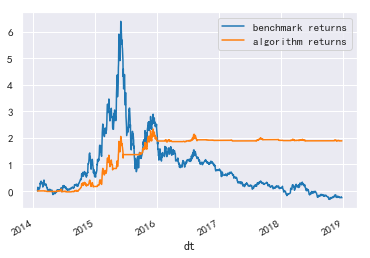

In [40]:
bt5.plot_returns_cmp(only_show_returns=True)

# 测试回测

2019年数据

In [36]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class': BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
    'sell_n': 20
}]
bt_2019 = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=17476 begin work'), FloatProgress(value=0.0)))

## 结果

In [37]:
print(gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略'),
                  bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略'),
                  bt_2019.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略(2019年数据)')], axis=1).T.to_markdown())

|                                                                     |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:--------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道                                           |   16441.3  |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |             -76.665  | 3.66 |  -0.223107 |        2209.86 |
| 回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略                |   16225.9  |    25080.6 |         52 |         27 |         25 |   0.519231 |              281.939 |              600.96  |             -62.6025 | 4.5  |  -0.223107 |        2217.84 |
| 回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）          |   16441.3  |    246

## 结果绘图

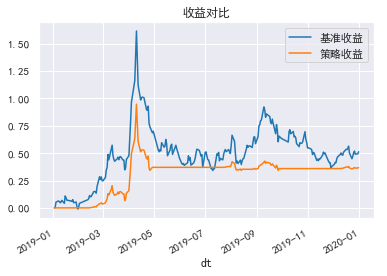

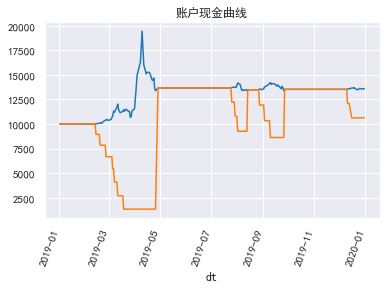

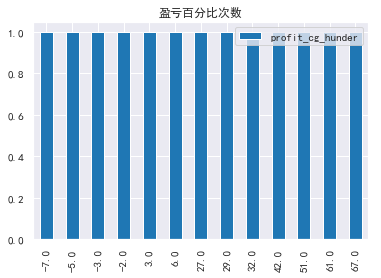

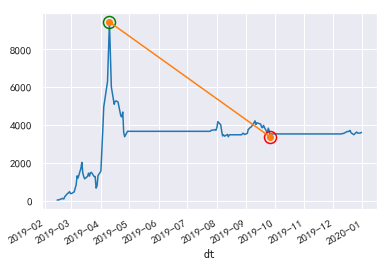

最大回撤: 0.312529
最大回测启始时间:2019-04-10, 结束时间2019-09-26, 共回测6078.167000
策略持股天数平均数: 53.000
策略持股天数中位数: 28.000


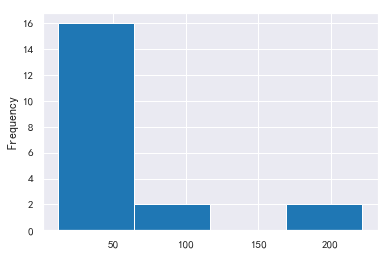

因子平均生效间隔:21.785714285714285


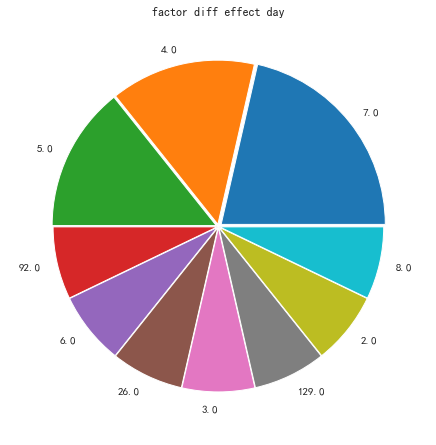

开仓花费情况: 
count:15
max:1707.8430087742447
min:1049.2495594025215
mean:1381.849161252182
std:177.04953762265478
skewness:-0.2906740811302359
kurtosis:-0.5591951252072662


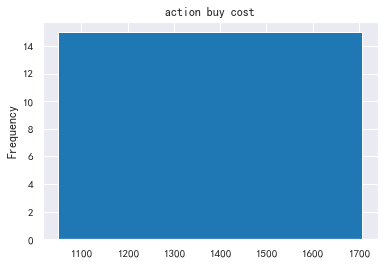

In [38]:
plot_cum_returns(bt_2019)
plot_capital_blance(bt_2019)
plot_win_loss_bar(bt_2019)
bt_2019.plot_max_draw_down()
bt_2019.plot_keep_days()
bt_2019.plot_effect_mean_day()
bt_2019.plot_action_buy_cost()

## 使用凯利公式对仓位进行管理

根据[回测-集合原始通道波幅+最多持仓天数+2倍ATR加仓的策略](#%E9%9B%86%E5%90%88%E5%8E%9F%E5%A7%8B%E9%80%9A%E9%81%93%E6%B3%A2%E5%B9%85+%E6%9C%80%E5%A4%9A%E6%8C%81%E4%BB%93%E5%A4%A9%E6%95%B0+2%E5%80%8DATR%E5%8A%A0%E4%BB%93%E7%9A%84%E7%AD%96%E7%95%A5)

- 胜率:58.44%
- 平均获利期望:19.26%
- 平均亏损期望:-3.80%

In [44]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt5.win_rate, 
                                        'gains_mean': bt5.gains_mean, 'losses_mean': -bt5.losses_mean}
    },
    {
        'class': BuyStrategy2,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt5.win_rate, 
                                        'gains_mean': bt5.gains_mean, 'losses_mean': -bt5.losses_mean}
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
    'sell_n': 20
}]
bt_2019_kelly = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=17476 begin work'), FloatProgress(value=0.0)))

### 结果

In [47]:
print(gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
                  bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略'),
                  bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略'),
                  bt_2019.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略(2019年数据)'),
                  bt_2019_kelly.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略+凯利公式仓位控制(2019年数据)')], axis=1).T.to_markdown())

|                                                                                      |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-------------------------------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-通道策略-ATR波幅通道                                                            |   16441.3  |    24605.9 |         52 |         28 |         24 |   0.538462 |              280.795 |              587.189 |             -76.665  | 3.66 |  -0.223107 |        2209.86 |
| 回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略                                 |   16225.9  |    25080.6 |         52 |         27 |         25 |   0.519231 |              281.939 |              600.96  |             -62.6025 | 4.5  |  -0.223107 |        2217.84 |
| 

### 结果绘图

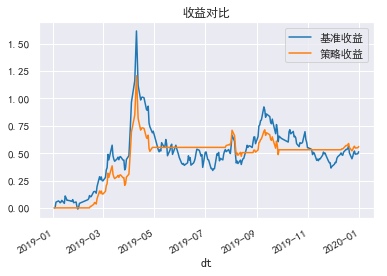

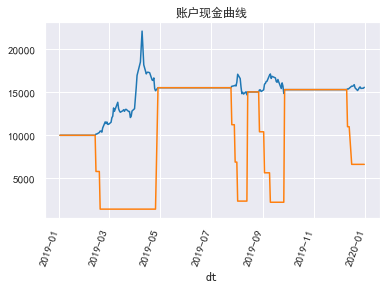

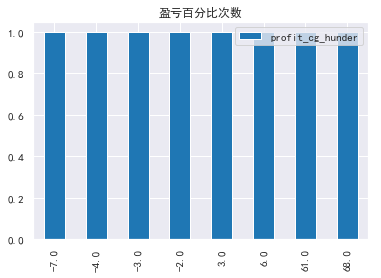

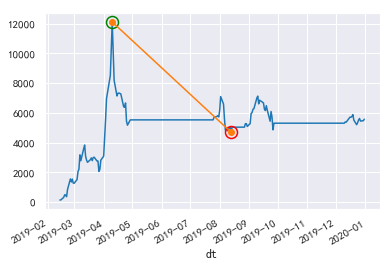

最大回撤: 0.335011
最大回测启始时间:2019-04-10, 结束时间2019-08-13, 共回测7406.549000
策略持股天数平均数: 53.000
策略持股天数中位数: 28.000


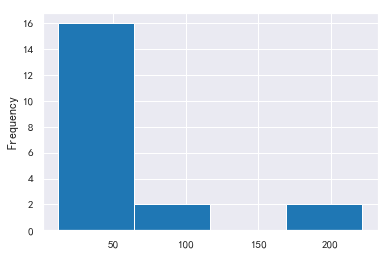

因子平均生效间隔:33.888888888888886


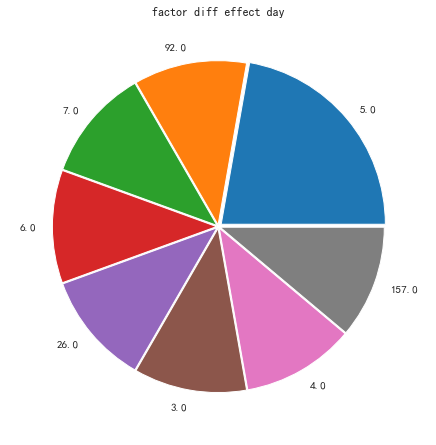

开仓花费情况: 
count:10
max:4758.954388696414
min:3415.6860175484894
mean:4319.477751291382
std:341.8574807843158
skewness:-1.5445639394014452
kurtosis:2.2387721221090437


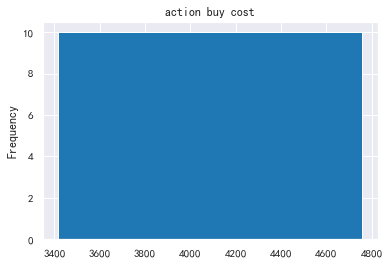

In [54]:
plot_cum_returns(bt_2019_kelly)
plot_capital_blance(bt_2019_kelly)
plot_win_loss_bar(bt_2019_kelly)
bt_2019_kelly.plot_max_draw_down()
bt_2019_kelly.plot_keep_days()
bt_2019_kelly.plot_effect_mean_day()
bt_2019_kelly.plot_action_buy_cost()

买入后卖出的交易数量:18
买入后尚未卖出的交易数量:2
胜率:61.1111%
平均获利期望:30.8059%
平均亏损期望:-6.1343%
盈亏比:5.2353
策略收益: 36.8669%
基准收益: 51.3113%
策略年化收益: 38.0756%
基准年化收益: 52.9937%
策略买入成交比例:75.0000%
策略资金利用率比例:19.5212%
策略共执行244个交易日


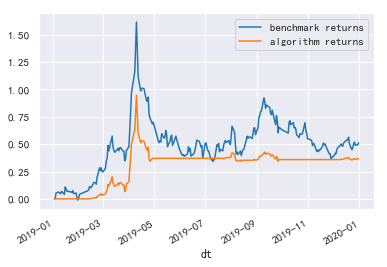

In [52]:
bt_2019.plot_returns_cmp(only_show_returns=True)

买入后卖出的交易数量:18
买入后尚未卖出的交易数量:2
胜率:61.1111%
平均获利期望:30.8058%
平均亏损期望:-6.1343%
盈亏比:8.6152
策略收益: 56.0843%
基准收益: 51.3113%
策略年化收益: 57.9231%
基准年化收益: 52.9937%
策略买入成交比例:50.0000%
策略资金利用率比例:31.1440%
策略共执行244个交易日


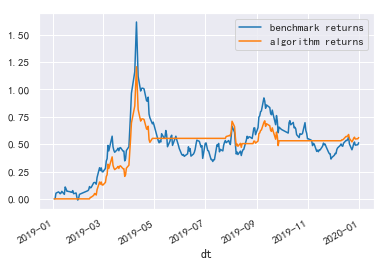

In [53]:
bt_2019_kelly.plot_returns_cmp(only_show_returns=True)

# 蒙特卡洛模拟

采用完整数据，从中随机选出500~1500天的连续数据，使用[凯利公式对仓位进行管理](#使用凯利公式对仓位进行管理)中的买卖策略进行测试。



In [87]:
import random
from QUANTAXIS.QAUtil.QADate import QA_util_datetime_to_strdate as dt2str
def generator():
    """随机选择迭代器"""
    while True:
        size=random.randint(500,1500)
        start=random.randint(0,len(ori_data_df_qfq)-size)
        end=start+size
        v= ori_data_df_qfq.iloc[start:end].reset_index()
        yield dt2str(v.iloc[0]['date'].date()),dt2str(v.iloc[-1]['date'].date())
g=generator()

In [142]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt5.win_rate, 
                                        'gains_mean': bt5.gains_mean, 'losses_mean': -bt5.losses_mean}
    },
    {
        'class': BuyStrategy2,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt5.win_rate, 
                                        'gains_mean': bt5.gains_mean, 'losses_mean': -bt5.losses_mean}
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
    'sell_n': 20
}]
def do_mc_test(times):
    from tqdm import tqdm_notebook
    test=[]
    for i in tqdm_notebook(range(times)):
        s,e=next(g)
#         logging.info('LEN:{}:{}~{}'.format(len(test),s,e))
        mc=backtest(buy_factors, sell_factors,start=s,end=e)
        if mc:
            test.append(mc)
    result=gquant.pd.concat([m.profit_series() for m in test],axis=1).T
    return result
def show_result(times,mcs):
    gquant.sns.distplot(mcs[mcs['交易次数']>=30]['R'])
    logging.info("测试{}次后交易次数>30的R乘数：\n{}".format(times,mcs[mcs['交易次数']>=30]['R'].describe()))

## 100次

In [ ]:
mcs100=do_mc_test(100)
show_result(100,mcs100)

## 1000次

In [ ]:
mcs1000=do_mc_test(1000)
show_result(1000,mcs1000)

## 10000次

In [ ]:
mcs10000=do_mc_test(10000)
show_result(10000,mcs10000)

In [154]:
mct=gquant.pd.DataFrame({100:mcs100[mcs100['交易次数']>=30]['R'].describe(),
                          1000:mcs100[mcs1000['交易次数']>=30]['R'].describe(),
                          10000:mcs100[mcs10000['交易次数']>=30]['R'].describe(),}).T
mct.index.name='测试轮数'
print(mct.to_markdown())

|   测试轮数 |   count |    mean |      std |   min |    25% |   50% |    75% |   max |
|-----------:|--------:|--------:|---------:|------:|-------:|------:|-------:|------:|
|        100 |      75 | 2.61867 | 0.998608 |  0.64 | 1.935  | 2.6   | 3.36   |  4.51 |
|       1000 |      66 | 2.5353  | 1.00721  |  0.64 | 1.8175 | 2.475 | 3.36   |  5.1  |
|      10000 |      60 | 2.4025  | 1.11402  |  0.05 | 1.5225 | 2.485 | 3.2625 |  4.62 |
